In [1]:
import json
import pandas as pd
from pathlib import Path
from pprint import pprint
import datetime
import time
import numpy as np
import matplotlib as plt

import pandas
import researchpy as rp
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

%matplotlib inline

In [2]:
path_results = Path('/media/discoD/models/elmo/ner/datalawyer')

In [3]:
for folder in path_results.iterdir():
    print(folder)

/media/discoD/models/elmo/ner/datalawyer/datalawyer-ft


In [5]:
configs = dict()
metrics = dict()
for folder in path_results.iterdir():
    results_model_folder = folder.iterdir()
    for training_folder in results_model_folder:
        #print('Reading files from %s' % training_folder.name)
        has_metrics = False
        for results_file in training_folder.iterdir():
            if results_file.name.endswith('.json'):
                #print('Parsing data from %s' % results_file.name)
                if results_file.name.startswith('config'):
                    configs[training_folder.name] = json.loads(results_file.read_bytes())
                elif results_file.name.startswith('metrics.'):
                    metrics[training_folder.name] = json.loads(results_file.read_bytes())
                    has_metrics = True
        if not has_metrics:
            print('metrics.json not found for %s' % training_folder.name)
            metrics[training_folder.name] = None
print(len(metrics))
print(len(configs))

9
9


In [6]:
def get_seconds(time_str):
    x = time.strptime(time_str,'%H:%M:%S')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
def get_average_epoch_duration(metrics):
    seconds = get_seconds(metrics['training_duration'])
    training_epochs = metrics['training_epochs'] + 1
    return seconds / training_epochs

In [16]:
TRAINING_ID = 'Training_ID'
SCENARIO = 'Scenario'
MODEL = 'Model'
EMBEDDING = 'Embedding'
EMBEDDING_TYPE = 'Embedding_Type'
DOMAN_SPECIFIC = 'Domain_Specific'
BATCH_SIZE = 'Batch_Size'
ELMO_DROPOUT = 'ELMo_Dropout'
TRAINING_NUMBER = 'Training_Number'
EXECUTION_NUMBER = 'Execution_Number'
BEST_EPOCH = 'Best_Epoch'
TRAINING_EPOCHS = 'Training_Epochs'
TRAINING_DURATION = 'Training_Duration'
TOTAL_DURATION = 'Total_Duration(s)'
AVERAGE_EPOCH_DURATION = 'Average_Epoch_Duration(s)'
TRAINING_ACCURACY = 'Training_Accuracy'
TRAINING_ACCURACY_TOP3 = 'Training_Accuracy_Top-3'
TRAINING_PRECISION = 'Training_Precision'
TRAINING_RECALL = 'Training_Recall'
TRAINING_F1_MEASURE = 'Training_F1-Measure'
TRAINING_LOSS = 'Training_Loss'
BEST_VALIDATION_ACCURACY = 'Best_Validation_Accuracy'
BEST_VALIDATION_ACCURACY_TOP3 = 'Best_Validation_Accuracy_Top-3'
BEST_VALIDATION_PRECISION = 'Best_Validation_Precision'
BEST_VALIDATION_RECALL = 'Best_Validation_Recall'
BEST_VALIDATION_F1_MEASURE = 'Best_Validation_F1-Measure'
BEST_VALIDATION_LOSS = 'Best_Validation_Loss'
TEST_ACCURACY = 'Test_Accuracy'
TEST_ACCURACY_TOP3 = 'Test_Accuracy_Top-3'
TEST_PRECISION = 'Test_Precision'
TEST_RECALL = 'Test_Recall'
TEST_F1_MEASURE = 'Test_F1_Measure'
TEST_LOSS = 'Test_Loss'
columns = [TRAINING_ID, MODEL, EMBEDDING, DOMAN_SPECIFIC, EMBEDDING_TYPE, TRAINING_NUMBER, EXECUTION_NUMBER, BEST_EPOCH, TRAINING_EPOCHS, TRAINING_DURATION, TOTAL_DURATION, AVERAGE_EPOCH_DURATION, TRAINING_ACCURACY, TRAINING_ACCURACY_TOP3, TRAINING_PRECISION, TRAINING_RECALL, TRAINING_F1_MEASURE, TRAINING_LOSS, BEST_VALIDATION_ACCURACY, BEST_VALIDATION_ACCURACY_TOP3, BEST_VALIDATION_PRECISION, BEST_VALIDATION_RECALL, BEST_VALIDATION_F1_MEASURE, BEST_VALIDATION_LOSS, TEST_ACCURACY, TEST_ACCURACY_TOP3, TEST_PRECISION, TEST_RECALL, TEST_F1_MEASURE, TEST_LOSS]
columns

['Training_ID',
 'Model',
 'Embedding',
 'Domain_Specific',
 'Embedding_Type',
 'Training_Number',
 'Execution_Number',
 'Best_Epoch',
 'Training_Epochs',
 'Training_Duration',
 'Total_Duration(s)',
 'Average_Epoch_Duration(s)',
 'Training_Accuracy',
 'Training_Accuracy_Top-3',
 'Training_Precision',
 'Training_Recall',
 'Training_F1-Measure',
 'Training_Loss',
 'Best_Validation_Accuracy',
 'Best_Validation_Accuracy_Top-3',
 'Best_Validation_Precision',
 'Best_Validation_Recall',
 'Best_Validation_F1-Measure',
 'Best_Validation_Loss',
 'Test_Accuracy',
 'Test_Accuracy_Top-3',
 'Test_Precision',
 'Test_Recall',
 'Test_F1_Measure',
 'Test_Loss']

In [26]:
def get_training_data_from_id(training_id, config):
    data = training_id.split('_')
    if len(data) == 4:
        # GloVe e None
        return {MODEL: data[0], EMBEDDING: data[1], DOMAN_SPECIFIC: False, EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[2], EXECUTION_NUMBER: data[3]}
    elif len(data) == 5:
        # GloVe Jur
        return {MODEL: data[0], EMBEDDING: data[1], DOMAN_SPECIFIC: True, EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[3], EXECUTION_NUMBER: data[4]}
    elif len(data) == 6:
        return {MODEL: data[0], EMBEDDING: data[1], DOMAN_SPECIFIC: True, EMBEDDING_TYPE: data[2], TRAINING_NUMBER: data[4], EXECUTION_NUMBER: data[5]}
    else:
        print('Invalid id: %s' % training_id)

In [27]:
training_data = []
for training_id, config in configs.items():
    training_metrics = metrics[training_id]
    data = get_training_data_from_id(training_id, config)
    data[TRAINING_ID] = training_id
    data[BEST_EPOCH] = training_metrics['best_epoch'] if training_metrics else None
    data[TRAINING_EPOCHS] = training_metrics['training_epochs'] + 1 if training_metrics else None
    data[TRAINING_DURATION] = training_metrics['training_duration'] if training_metrics else None
    data[TOTAL_DURATION] = get_seconds(training_metrics['training_duration']) if training_metrics else None
    data[AVERAGE_EPOCH_DURATION] = get_average_epoch_duration(training_metrics) if training_metrics else None
    data[TRAINING_ACCURACY] = training_metrics['training_accuracy'] if training_metrics else None
    data[TRAINING_ACCURACY_TOP3] = training_metrics['training_accuracy3'] if training_metrics else None
    data[TRAINING_PRECISION] = training_metrics['training_precision-overall'] if training_metrics else None
    data[TRAINING_RECALL] = training_metrics['training_recall-overall'] if training_metrics else None
    data[TRAINING_F1_MEASURE] = training_metrics['training_f1-measure-overall'] if training_metrics else None
    data[TRAINING_LOSS] = training_metrics['training_loss'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY] = training_metrics['best_validation_accuracy'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY_TOP3] = training_metrics['best_validation_accuracy3'] if training_metrics else None
    data[BEST_VALIDATION_PRECISION] = training_metrics['best_validation_precision-overall'] if training_metrics else None
    data[BEST_VALIDATION_RECALL] = training_metrics['best_validation_recall-overall'] if training_metrics else None
    data[BEST_VALIDATION_F1_MEASURE] = training_metrics['best_validation_f1-measure-overall'] if training_metrics else None
    data[BEST_VALIDATION_LOSS] = training_metrics['best_validation_loss'] if training_metrics else None
    data[TEST_ACCURACY] = training_metrics['test_accuracy'] if training_metrics else None
    data[TEST_ACCURACY_TOP3] = training_metrics['test_accuracy3'] if training_metrics else None
    data[TEST_PRECISION] = training_metrics['test_precision-overall'] if training_metrics else None
    data[TEST_RECALL] = training_metrics['test_recall-overall'] if training_metrics else None
    data[TEST_F1_MEASURE] = training_metrics['test_f1-measure-overall'] if training_metrics else None
    data[TEST_LOSS] = training_metrics['test_loss'] if training_metrics else None
    training_data.append(data)

In [28]:
pd.set_option('display.max_columns', 1000)
training_data_df = pd.DataFrame(training_data, columns=columns)
training_data_df

,Training_ID,Model,Embedding,Domain_Specific,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,datalawyer_fasttext_cbow_jur_0_0,datalawyer,fasttext,True,cbow,0,0,14,20,01:22:34,4954.0,247.70,0.992319,0.992708,0.917529,0.911837,0.914674,11.156613,0.988625,0.989069,0.879412,0.900602,0.889881,22.052143,0.986024,0.986587,0.845455,0.874608,0.859784,30.901843
1,datalawyer_fasttext_skip_jur_0_0,datalawyer,fasttext,True,skip,0,0,12,20,01:19:57,4797.0,239.85,0.996208,0.996338,0.954501,0.955592,0.955046,6.357921,0.988736,0.989032,0.879527,0.896084,0.887728,30.257647,0.984510,0.985020,0.841660,0.858150,0.849825,45.842382
2,datalawyer_glove_0_0,datalawyer,glove,False,No,0,0,18,20,01:19:37,4777.0,238.85,0.996377,0.996523,0.959837,0.959837,0.959837,6.021274,0.987497,0.987867,0.893048,0.880271,0.886614,37.799094,0.987203,0.987643,0.866092,0.866771,0.866432,44.499107
3,datalawyer_glove_jur_0_0,datalawyer,glove,True,No,0,0,14,20,01:18:11,4691.0,234.55,0.996127,0.996296,0.954345,0.955592,0.954968,6.500476,0.988847,0.989217,0.886891,0.891566,0.889223,28.012386,0.986957,0.987449,0.860896,0.873041,0.866926,37.865415
4,datalawyer_none_0_0,datalawyer,none,False,No,0,0,17,20,01:17:26,4646.0,232.30,0.995489,0.995697,0.949133,0.947429,0.948280,7.508642,0.988052,0.988348,0.879733,0.892319,0.885981,30.401057,0.985513,0.986112,0.834225,0.855799,0.844874,39.785256
5,datalawyer_wang2vec_cbow_jur_0_0,datalawyer,wang2vec,True,cbow,0,0,14,20,01:18:51,4731.0,236.55,0.995927,0.996104,0.954708,0.956735,0.955720,6.271267,0.987405,0.987756,0.886976,0.892319,0.889640,32.789060,0.986428,0.987062,0.851966,0.865987,0.858920,42.608721
6,datalawyer_wang2vec_skip_jur_0_0,datalawyer,wang2vec,True,skip,0,0,10,20,01:18:50,4730.0,236.50,0.996089,0.996258,0.958265,0.955918,0.957090,6.304842,0.987405,0.987700,0.878338,0.891566,0.884903,31.122399,0.986816,0.987361,0.843465,0.869906,0.856481,38.225307
7,datalawyer_word2vec_cbow_jur_0_0,datalawyer,word2vec,True,cbow,0,0,15,20,01:19:32,4772.0,238.60,0.993876,0.994160,0.930396,0.927510,0.928951,9.237478,0.988015,0.988366,0.885331,0.895331,0.890303,27.920659,0.986340,0.986904,0.848739,0.870690,0.859574,36.435839
8,datalawyer_word2vec_skip_jur_0_0,datalawyer,word2vec,True,skip,0,0,17,20,01:18:25,4705.0,235.25,0.996196,0.996392,0.954137,0.954449,0.954293,6.120676,0.988570,0.988940,0.889722,0.893072,0.891394,32.864755,0.986129,0.986728,0.851623,0.863636,0.857588,46.482926


In [29]:
training_data_df.to_csv('training_data_20_epochs_mestrado_datalawyer.csv', index=None)

In [30]:
str(datetime.timedelta(seconds=training_data_df[TOTAL_DURATION].mean()))

'1:19:15.888889'

In [34]:
training_data_df.groupby([EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding_Type,,,,,,,,
cbow,3.0,0.859426,0.000451,0.858920,0.859247,0.859574,0.859679,0.859784
No,3.0,0.859411,0.012591,0.844874,0.855653,0.866432,0.866679,0.866926
skip,3.0,0.854631,0.004199,0.849825,0.853153,0.856481,0.857035,0.857588


In [31]:
training_data_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
glove,2.0,0.866679,0.000350,0.866432,0.866555,0.866679,0.866802,0.866926
word2vec,2.0,0.858581,0.001405,0.857588,0.858084,0.858581,0.859078,0.859574
wang2vec,2.0,0.857701,0.001724,0.856481,0.857091,0.857701,0.858310,0.858920
fasttext,2.0,0.854805,0.007042,0.849825,0.852315,0.854805,0.857295,0.859784
none,1.0,0.844874,NaN,0.844874,0.844874,0.844874,0.844874,0.844874


In [32]:
training_data_df.groupby([EMBEDDING, EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,,count,mean,std,min,25%,50%,75%,max
Embedding,Embedding_Type,,,,,,,,
glove,No,2.0,0.866679,0.00035,0.866432,0.866555,0.866679,0.866802,0.866926
fasttext,cbow,1.0,0.859784,NaN,0.859784,0.859784,0.859784,0.859784,0.859784
word2vec,cbow,1.0,0.859574,NaN,0.859574,0.859574,0.859574,0.859574,0.859574
wang2vec,cbow,1.0,0.858920,NaN,0.858920,0.858920,0.858920,0.858920,0.858920
word2vec,skip,1.0,0.857588,NaN,0.857588,0.857588,0.857588,0.857588,0.857588
wang2vec,skip,1.0,0.856481,NaN,0.856481,0.856481,0.856481,0.856481,0.856481
fasttext,skip,1.0,0.849825,NaN,0.849825,0.849825,0.849825,0.849825,0.849825
none,No,1.0,0.844874,NaN,0.844874,0.844874,0.844874,0.844874,0.844874


In [25]:
training_data_df.groupby([EMBEDDING, DOMAN_SPECIFIC]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

count      mean       std       min       25%  \
Embedding Domain_Specific                                                  
glove     True               1.0  0.866926       NaN  0.866926  0.866926   
          False              1.0  0.866432       NaN  0.866432  0.866432   
word2vec  True               2.0  0.858581  0.001405  0.857588  0.858084   
wang2vec  True               2.0  0.857701  0.001724  0.856481  0.857091   
fasttext  True               2.0  0.854805  0.007042  0.849825  0.852315   
none      False              1.0  0.844874       NaN  0.844874  0.844874   

                                50%       75%       max  
Embedding Domain_Specific                                
glove     True             0.866926  0.866926  0.866926  
          False            0.866432  0.866432  0.866432  
word2vec  True             0.858581  0.859078  0.859574  
wang2vec  True             0.857701  0.858310  0.858920  
fasttext  True             0.854805  0.857295  0.859784  
none      False            0.844874  0.844874  0.844874

In [33]:
training_data_df.groupby([EMBEDDING, EMBEDDING_TYPE, DOMAN_SPECIFIC]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

count      mean  std       min  \
Embedding Embedding_Type Domain_Specific                                   
glove     No             True               1.0  0.866926  NaN  0.866926   
                         False              1.0  0.866432  NaN  0.866432   
fasttext  cbow           True               1.0  0.859784  NaN  0.859784   
word2vec  cbow           True               1.0  0.859574  NaN  0.859574   
wang2vec  cbow           True               1.0  0.858920  NaN  0.858920   
word2vec  skip           True               1.0  0.857588  NaN  0.857588   
wang2vec  skip           True               1.0  0.856481  NaN  0.856481   
fasttext  skip           True               1.0  0.849825  NaN  0.849825   
none      No             False              1.0  0.844874  NaN  0.844874   

                                               25%       50%       75%  \
Embedding Embedding_Type Domain_Specific                                 
glove     No             True             0.866926  0.866926  0.866926   
                         False            0.866432  0.866432  0.866432   
fasttext  cbow           True             0.859784  0.859784  0.859784   
word2vec  cbow           True             0.859574  0.859574  0.859574   
wang2vec  cbow           True             0.858920  0.858920  0.858920   
word2vec  skip           True             0.857588  0.857588  0.857588   
wang2vec  skip           True             0.856481  0.856481  0.856481   
fasttext  skip           True             0.849825  0.849825  0.849825   
none      No             False            0.844874  0.844874  0.844874   

                                               max  
Embedding Embedding_Type Domain_Specific            
glove     No             True             0.866926  
                         False            0.866432  
fasttext  cbow           True             0.859784  
word2vec  cbow           True             0.859574  
wang2vec  cbow           True             0.858920  
word2vec  skip           True             0.857588  
wang2vec  skip           True             0.856481  
fasttext  skip           True             0.849825  
none      No             False            0.844874

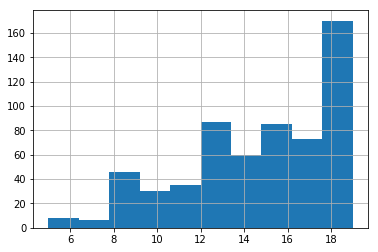

In [21]:
training_data_df[BEST_EPOCH].hist()

In [22]:
training_data_df[TOTAL_DURATION].describe()

count     600.000000
mean     1327.020000
std        44.693573
min       720.000000
25%      1315.000000
50%      1327.500000
75%      1342.000000
max      1481.000000
Name: Total_Duration(s), dtype: float64

In [23]:
training_data_df.groupby([TRAINING_NUMBER]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Training_Number,,,,,,,,
5,60.0,0.817379,0.004672,0.804829,0.814010,0.817266,0.820578,0.826608
4,60.0,0.814128,0.005210,0.800135,0.810515,0.814865,0.817634,0.824570
7,60.0,0.813771,0.004706,0.797168,0.811285,0.814201,0.816225,0.824929
3,60.0,0.813727,0.004833,0.796454,0.811479,0.814295,0.816585,0.823165
6,60.0,0.813093,0.004917,0.803619,0.809540,0.813154,0.816136,0.825911
1,60.0,0.812906,0.006185,0.796196,0.809025,0.813254,0.818081,0.824207
8,60.0,0.812102,0.004333,0.803045,0.809669,0.812329,0.815178,0.821890
2,60.0,0.811337,0.005657,0.799863,0.806218,0.812500,0.814636,0.822117
0,60.0,0.810667,0.005498,0.799242,0.807569,0.811539,0.813724,0.822804


In [24]:
rp.summary_cont(training_data_df[TEST_F1_MEASURE])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Test_F1_Measure,600.0,0.812901,0.005657,0.000231,0.812447,0.813354


In [25]:
rp.summary_cont(training_data_df.groupby(MODEL))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Model,,,,,,
harem,300,0.812728,0.005699,0.000329,0.812083,0.813372
harem-ft,300,0.813074,0.005619,0.000324,0.812438,0.813709


In [26]:
rp.summary_cont(training_data_df.groupby(EMBEDDING))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Embedding,,,,,,
fasttext,120,0.812345,0.005017,0.000458,0.811447,0.813243
glove,120,0.814403,0.005823,0.000532,0.813361,0.815444
none,120,0.812689,0.005391,0.000492,0.811725,0.813654
wang2vec,120,0.813924,0.006053,0.000553,0.812841,0.815007
word2vec,120,0.811142,0.005433,0.000496,0.810170,0.812114


In [27]:
rp.summary_cont(training_data_df.groupby([MODEL,EMBEDDING]))[TEST_F1_MEASURE]

N      Mean        SD        SE  95% Conf.  Interval
Model    Embedding                                                       
harem    fasttext   60  0.812446  0.005506  0.000711   0.811053  0.813839
         glove      60  0.812901  0.005731  0.000740   0.811451  0.814351
         none       60  0.812162  0.005278  0.000681   0.810827  0.813498
         wang2vec   60  0.814325  0.006491  0.000838   0.812682  0.815967
         word2vec   60  0.811804  0.005249  0.000678   0.810475  0.813132
harem-ft fasttext   60  0.812244  0.004521  0.000584   0.811100  0.813388
         glove      60  0.815904  0.005565  0.000718   0.814496  0.817312
         none       60  0.813217  0.005494  0.000709   0.811826  0.814607
         wang2vec   60  0.813523  0.005608  0.000724   0.812104  0.814942
         word2vec   60  0.810480  0.005575  0.000720   0.809069  0.811890

In [28]:
print(TEST_F1_MEASURE, MODEL, EMBEDDING, BATCH_SIZE, ELMO_DROPOUT)

Test_F1_Measure Model Embedding Batch_Size ELMo_Dropout


In [29]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def print_anova(parameter):
    # Fits the model with the interaction term
    # This will also automatically include the main effects for each factor
    model = ols('Test_F1_Measure ~ C({0})'.format(parameter), training_data_df).fit()
    # Seeing if the overall model is significant
    print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .20f}")
    print(model.summary())
    res = sm.stats.anova_lm(model, typ= 2)
    print(res)
    print(anova_table(res))
    mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[parameter])
    mc_results = mc.tukeyhsd()
    print(mc_results)

In [30]:
print_anova(MODEL)

Overall model F( 1, 598) =  0.561, p =  0.45425607932819933588
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.5607
Date:                Sun, 19 May 2019   Prob (F-statistic):              0.454
Time:                        08:34:41   Log-Likelihood:                 2254.3
No. Observations:                 600   AIC:                            -4505.
Df Residuals:                     598   BIC:                            -4496.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

In [31]:
print_anova(EMBEDDING)

Overall model F( 4, 595) =  6.563, p =  0.00003585878067636342
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     6.563
Date:                Sun, 19 May 2019   Prob (F-statistic):           3.59e-05
Time:                        08:34:41   Log-Likelihood:                 2267.0
No. Observations:                 600   AIC:                            -4524.
Df Residuals:                     595   BIC:                            -4502.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [32]:
training_data_df[training_data_df[TRAINING_EPOCHS] != 20]

,Training_ID,Scenario,Model,Embedding,Batch_Size,ELMo_Dropout,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
105,selective_harem-ft_none_64_0_6_5,selective,harem-ft,none,64,0,6,5,19,11,00:12:00,720.0,65.454545,0.997117,0.997366,0.967707,0.965872,0.966789,12.444265,0.986527,0.987425,0.862884,0.894608,0.878460,99.499225,0.977531,0.979407,0.817379,0.804007,0.810638,181.813948
163,selective_harem-ft_none_64_0_6_1,selective,harem-ft,none,64,0,6,1,19,11,00:12:12,732.0,66.545455,0.997321,0.997524,0.968056,0.968581,0.968318,12.424200,0.985329,0.986327,0.846154,0.889706,0.867384,103.369963,0.976826,0.978582,0.812224,0.798664,0.805387,194.661306
456,selective_harem_none_64_0_9_3,selective,harem,none,64,0,9,3,12,15,00:16:31,991.0,66.066667,0.997620,0.997768,0.975258,0.969722,0.972482,10.080244,0.981608,0.983761,0.847291,0.857855,0.852540,126.168685,0.977411,0.979302,0.824100,0.794658,0.809111,151.783507


In [33]:
datalawyer_results_paths = ['/media/discoD/models/elmo/ner_elmo_datalawyer_no_tokens/',
'/media/discoD/models/elmo/ner_glove_jur_elmo/',
'/media/discoD/models/elmo/ner_jur2vec_cbow_elmo/',
'/media/discoD/models/elmo/ner_jur2vec_skip_elmo/']

In [34]:
dl_configs = dict()
dl_metrics = dict()
for results_path in datalawyer_results_paths:
    path = Path(results_path)
    print(path.name)
    config_path = path / 'config.json'
    metrics_path = path / 'metrics.json'
    dl_configs[path.name] = json.loads(config_path.read_bytes())
    dl_metrics[path.name] = json.loads(metrics_path.read_bytes())

ner_elmo_datalawyer_no_tokens


FileNotFoundError: [Errno 2] No such file or directory: '/media/discoD/models/elmo/ner_elmo_datalawyer_no_tokens/config.json'

In [ ]:
training_data = []
for training_id, config in dl_configs.items():
    training_metrics = dl_metrics[training_id]
    data = dict()
    data[EMBEDDING] = training_id
    for metric, value in training_metrics.items():
        if metric.startswith('test_f1-measure'):
            data[metric] = value
    data['best_epoch'] = training_metrics['best_epoch']
    data['training_duration'] = training_metrics['training_duration']
    data['training_duration_s'] = get_seconds(training_metrics['training_duration'])
    data['training_epochs'] = training_metrics['training_epochs']
    training_data.append(data)

In [ ]:
training_data_dl_df = pd.DataFrame(training_data)
training_data_dl_df

In [ ]:
training_data_dl_df.sort_values('test_f1-measure-overall')

In [ ]:
str(datetime.timedelta(seconds=training_data_dl_df['training_duration_s'].mean()))

In [ ]:
training_data_dl_df['training_epochs'].mean()